[View in Colaboratory](https://colab.research.google.com/github/Neelkamal692/ML/blob/master/salt_identification.ipynb)

In [0]:
#File input output
import os
#matrix math
import numpy as np
#read/write image data
import imageio
#visualize data
import matplotlib.pyplot as plt
#data preprocessing 
import pandas as pd
#deep learning
import torch
#just in case we need a backup datasets
from torch.utils import data
#will output the plot right below the cell that produces it
%matplotlib inline


In [27]:
from google.colab import files
files.upload()




Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"neelkamal692","key":"f116b61b1beb446c60bac5f53ef034f1"}'}

In [0]:


# The Kaggle API client expects this file to be in ~/.kaggle,
# so lets move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json



In [29]:
!kaggle competitions download -c tgs-salt-identification-challenge

depths.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.zip: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)


In [30]:
#and we'll need those training images unzipped
!ls
!unzip train.zip

depths.csv	 kaggle.json	      sample_data	     train.csv
images		 masks		      sample_submission.csv  train.zip
kaggle (1).json  model-tgs-salt-1.h5  test.zip
Archive:  train.zip
replace images/8d08955cdf.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
class TGSSaltDataset(data.Dataset):
  
  def __init__(self,root_path,file_list):
    self.root_path=root_path
    self.file_list=file_list
    
  def __len__(self):
    return len(self.file_list)
  
  def __getitem__ (self,index):
    file_id=self.file_list[index]
    #image folder+path
    image_folder=os.path.join(self.root_path,'images')
    image_path=os.path.join(image_folder,file_id+'.png') 
    
    #label folder +path
    mask_folder=os.path.join(self.root_path,'masks')
    mask_path=os.path.join(mask_folder,file_id + '.png')
    #read it
    image = np.array(imageio.imread(image_path),dtype=np.uint8)
    mask = np.array(imageio.imread(mask_path),dtype=np.uint8)
    return image,mask 
  
  

In [0]:
train_mask=pd.read_csv('train.csv')
test_mask=pd.read_csv('test.csv')
print(test_mask.head())
depth = pd.read_csv('depths.csv')
train_path = './'
file_list = list(train_mask['id'].values)
dataset = TGSSaltDataset(train_path,file_list)

In [0]:
def plot2x2array(image,mask):
  f,axarr=plt.subplots(1,2)
  axarr[0].imshow(image)
  axarr[1].imshow(mask)
  axarr[0].grid()
  axarr[1].grid()
  axarr[0].set_title('Image')
  axarr[1].set_title('Mask')

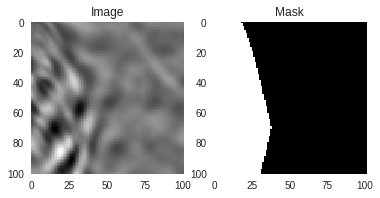

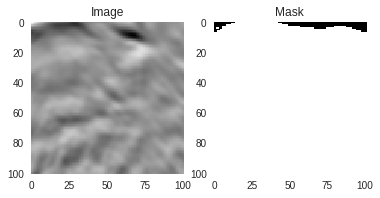

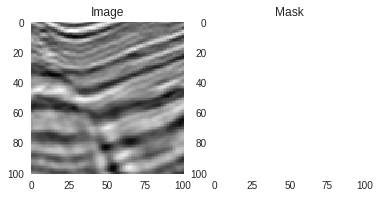

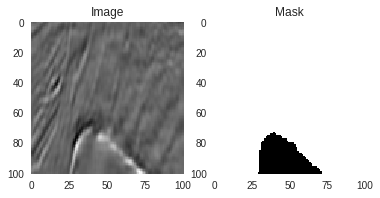

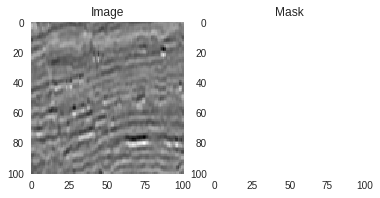

In [12]:
for i in range(5):
  image,mask = dataset[np.random.randint(0,len(dataset))]
  plot2x2array(image,mask)

In [0]:
#convert to image
def rleToMask(rleString,height,width):
    #width heigh
    rows,cols = height,width
    try:
        #get numbers
        rleNumbers = [int(numstring) for numstring in rleString.split(' ')]
        #get pairs
        rlePairs = np.array(rleNumbers).reshape(-1,2)
        #create an image
        img = np.zeros(rows*cols,dtype=np.uint8)
        #for each pair
        for index,length in rlePairs:
            #get the pixel value 
            index -= 1
            img[index:index+length] = 255
        
        
        #reshape
        img = img.reshape(cols,rows)
        img = img.T
    
    #else return empty image
    except:
        img = np.zeros((cols,rows))
    
    return img

In [0]:
#for measuring how salty an image is
def salt_proportion(imgArray):
    try: 
        unique, counts = np.unique(imgArray, return_counts=True)
        ## The total number of pixels is 101*101 = 10,201
        return counts[1]/10201.
    
    except: 
        return 0.0

In [0]:


train_mask['mask'] = train_mask['rle_mask'].apply(lambda x: rleToMask(x, 101,101))
train_mask['salt_proportion'] = train_mask['mask'].apply(lambda x: salt_proportion(x))



In [16]:


merged = train_mask.merge(depth, how = 'left')
merged.head()



,id,rle_mask,mask,salt_proportion,z
0,575d24d81d,NaN,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,843
1,a266a2a9df,5051 5151,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.504950,794
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.993334,468
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.149201,727
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.042839,797


Text(0.5,1,'Proportion of salt v. depth')

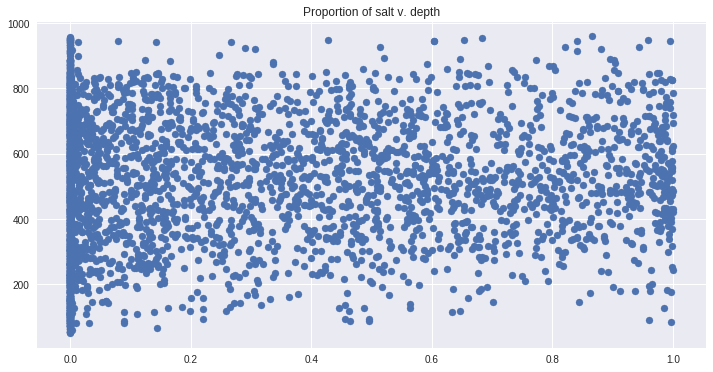

In [17]:


plt.figure(figsize = (12, 6))
plt.scatter(merged['salt_proportion'], merged['z'])
plt.title('Proportion of salt v. depth')



In [18]:
print("Correlation: ", np.corrcoef(merged['salt_proportion'], merged['z'])[0, 1])

Correlation:  0.10361580365557428


In [19]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

Using TensorFlow backend.


In [0]:
im_width = 128
im_height = 128
border = 5
im_chan = 2 # Number of channels: first is original and second cumsum(axis=0)
n_features = 1 # Number of extra features, like depth
#path_train = '../input/train/'
#path_test = '../input/test/'


In [21]:
# Build U-Net model
input_img = Input((im_height, im_width, im_chan), name='img')
input_features = Input((n_features, ), name='feat')

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (input_img)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

# Join features information in the depthest layer
f_repeat = RepeatVector(8*8)(input_features)
f_conv = Reshape((8, 8, n_features))(f_repeat)
p4_feat = concatenate([p4, f_conv], -1)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4_feat)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
#check out this skip connection thooooo
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[input_img, input_features], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy') #, metrics=[mean_iou]) # The mean_iou metrics seens to leak train and test values...
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 2)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  152         img[0][0]                        
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 8)    0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [22]:


import sys
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.transform import resize


train_ids = next(os.walk(train_path+"images"))[2]


# Get and resize train images and masks
X = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.float32)
y = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.float32)
X_feat = np.zeros((len(train_ids), n_features), dtype=np.float32)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = train_path
    
    # Depth
    #X_feat[n] = depth.loc[id_.replace('.png', ''), 'z']
    
    # Load X
    img = load_img(path + '/images/' + id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode='constant', preserve_range=True)
    
    # Create cumsum x
    x_center_mean = x_img[border:-border, border:-border].mean()
    x_csum = (np.float32(x_img)-x_center_mean).cumsum(axis=0)
    x_csum -= x_csum[border:-border, border:-border].mean()
    x_csum /= max(1e-3, x_csum[border:-border, border:-border].std())

    # Load Y
    mask = img_to_array(load_img(path + '/masks/' + id_, grayscale=True))
    mask = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

    # Save images
    X[n, ..., 0] = x_img.squeeze() / 255
    X[n, ..., 1] = x_csum.squeeze()
    y[n] = mask / 255

print('Done!')



Getting and resizing train images and masks ... 


100%|██████████| 4000/4000 [00:19<00:00, 205.62it/s]

Done!


In [0]:
from sklearn.model_selection import train_test_split

X_train, X_valid, X_feat_train, X_feat_valid, y_train, y_valid = train_test_split(X, X_feat, y, test_size=0.15, random_state=42)

In [24]:
callbacks = [
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(patience=3, verbose=1),
    ModelCheckpoint('model-tgs-salt-1.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

results = model.fit({'img': X_train, 'feat': X_feat_train}, y_train, batch_size=16, epochs=5, callbacks=callbacks,
                    validation_data=({'img': X_valid, 'feat': X_feat_valid}, y_valid))

Train on 3400 samples, validate on 600 samples
Epoch 1/5
3400/3400 [==============================] - 283s 83ms/step - loss: 0.5751 - val_loss: 0.5683

Epoch 00001: val_loss improved from inf to 0.56826, saving model to model-tgs-salt-1.h5
Epoch 2/5
3400/3400 [==============================] - 279s 82ms/step - loss: 0.5509 - val_loss: 0.5741

Epoch 00002: val_loss did not improve from 0.56826
Epoch 3/5
3400/3400 [==============================] - 277s 81ms/step - loss: 0.5077 - val_loss: 0.4728

Epoch 00003: val_loss improved from 0.56826 to 0.47276, saving model to model-tgs-salt-1.h5
Epoch 4/5
3400/3400 [==============================] - 278s 82ms/step - loss: 0.4311 - val_loss: 0.4008

Epoch 00004: val_loss improved from 0.47276 to 0.40082, saving model to model-tgs-salt-1.h5
Epoch 5/5
3400/3400 [==============================] - 276s 81ms/step - loss: 0.3575 - val_loss: 0.3225

Epoch 00005: val_loss improved from 0.40082 to 0.32254, saving model to model-tgs-salt-1.h5
